# 卒業研究：TRAPPIST-1dとeのトランジット解析

<font color="CornflowerBlue">青色：疑問点、改良したい点</font>

## 0. 解析に必要なモジュールの準備

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

#styling
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
fontsize=18

## 1. データフレームの準備

### 1-1 測光結果を読み込む

測光には福井さんのプログラムafapphotを用いた。  
様々なアパーチャー半径で測光した結果、目で見てライトカーブが綺麗に見えるアパーチャー半径として様々な半径を用意した。  
以下で行うフィッティングを様々な半径で行なった結果BIC等の基準から最も良くフィッティングできた半径として、12,13,14pixを残す。

In [2]:
df = pd.read_csv('TRAPPIST-1_171105_zband.csv', delimiter=',', parse_dates=True)
df = df.drop(['Unnamed: 0'],axis=1)
df.head()

,GJD-2450000,airmass,sky,dx,dy,flux(10),err(10),flux(11),err(11),flux(12),err(12),flux(13),err(13),flux(14),err(14),flux(15),err(15)
0,8062.876429,1.5601,1109.2,-0.027,-2.954,0.998611,0.004243,0.999285,0.004415,0.997248,0.004615,0.997372,0.004839,0.997539,0.005075,0.995310,0.005315
1,8062.877054,1.5560,979.4,-0.084,-2.454,1.003984,0.004132,1.004214,0.004304,1.004072,0.004506,1.003590,0.004729,1.005631,0.004968,1.005165,0.005211
2,8062.877679,1.5516,875.1,-0.130,-1.302,1.006406,0.004044,1.004540,0.004190,1.004198,0.004377,1.003489,0.004581,1.003510,0.004800,1.003624,0.005028
3,8062.878316,1.5472,784.6,-0.433,0.046,1.009209,0.003988,1.008103,0.004117,1.008610,0.004289,1.007227,0.004478,1.007392,0.004681,1.008025,0.004896
4,8062.878941,1.5433,710.4,0.116,-1.458,1.004208,0.003871,1.005043,0.004000,1.005238,0.004162,1.006522,0.004346,1.007340,0.004539,1.006270,0.004736


In [3]:
len(df)

306

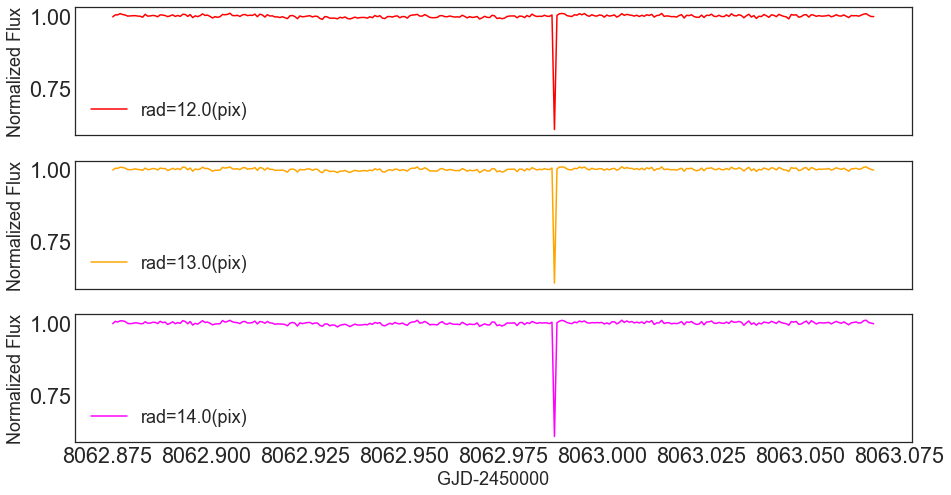

In [4]:
fig,ax = pl.subplots(3,1,figsize=(15,8),sharex=True)

time = df['GJD-2450000']
flux = [ df['flux(12)'],df['flux(13)'],df['flux(14)']]


colors = ['red','orange','magenta']
radii = ['rad=12.0(pix)','rad=13.0(pix)','rad=14.0(pix)']
n=0

# for each band and color do the following:
for c,r in zip(colors,radii):
    ax[n].plot(time, flux[n], label=r, color = c)
    
    #add plot labels
    ax[2].set_xlabel('GJD-2450000')
    ax[n].set_ylabel('Normalized Flux')
    ax[n].legend(loc='lower left')
    
    #increase the axis counter
    n=n+1

pl.savefig('figures/flux_with_outlier.png')

### 1-2 外れ値を除く

上のグラフから、1箇所明らかに外れている値があるのがわかる。確認したところすべておなじフレーム(MSCT2_1711050228)のデータだったので、fluxの平均から$5\sigma$以上離れている点を除くと、その1点だけが除かれた。
<font color="CornflowerBlue">ds9でMSCT2_1711050228.fitsを確認したが特におかしなところが見つからなかった。なぜこんな外れ値が出たのか、irafで測光してみるべきか</font>

In [5]:
sigma = 5
df=df[np.abs(df['flux(12)']-df['flux(12)'].mean())<=(sigma*df['flux(12)'].std())]

In [6]:
len(df)

305

また、airmassについても1点だけおかしい点があったので同様に除いた。

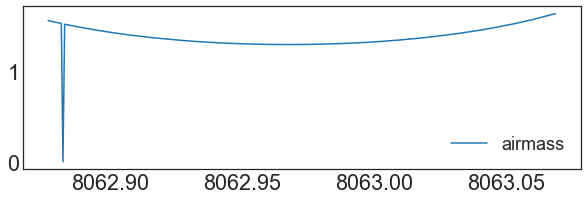

In [7]:
fig,ax = pl.subplots(1,1,figsize=(10,3))
ax.plot(df['GJD-2450000'],df['airmass'],label='airmass')
ax.legend(loc='lower right')

In [8]:
sigma = 5
df=df[np.abs(df['airmass']-df['airmass'].mean())<=(sigma*df['airmass'].std())]

In [9]:
len(df)

304

データ点は304点、プロットすると以下のようになる。

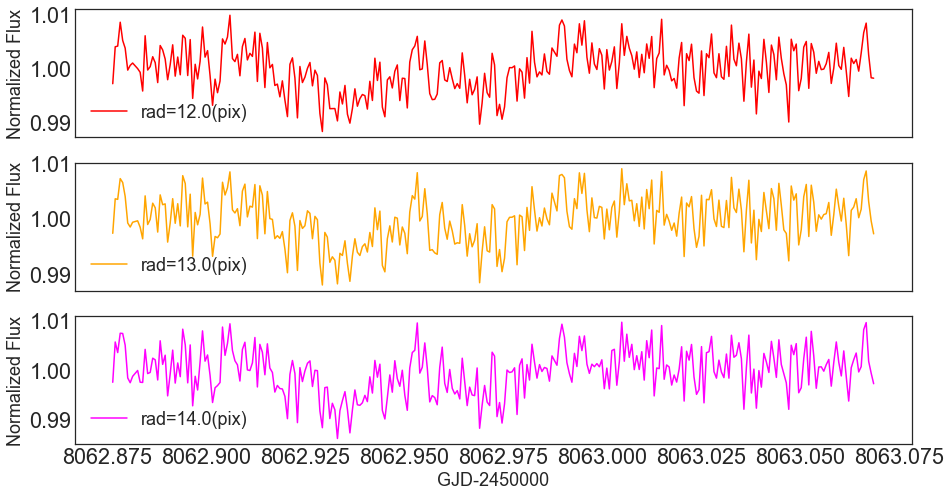

In [10]:
fig,ax = pl.subplots(3,1,figsize=(15,8),sharex=True)

time = df['GJD-2450000']
flux = [ df['flux(12)'],df['flux(13)'],df['flux(14)']]


colors = ['red','orange','magenta']
radii = ['rad=12.0(pix)','rad=13.0(pix)','rad=14.0(pix)']
n=0

# for each band and color do the following:
for c,r in zip(colors,radii):
    ax[n].plot(time, flux[n], label=r, color = c)
    
    #add plot labels
    ax[2].set_xlabel('GJD-2450000')
    ax[n].set_ylabel('Normalized Flux')
    ax[n].legend(loc='lower left')
    
    #increase the axis counter
    n=n+1

pl.savefig('figures/flux_3rad.pdf')

左側の凹みがe、右側がdのトランジットと予想されるが、確認はモデルフィットの際に行う。  
最終的に用いるアパーチャー半径は、以下でモデルフィットした際にrmsが一番小さくなるものとする。

## 2. モデルの準備

### 2-1 必要な物理量の代入

In [11]:
from astropy import units as u

#values come from S.Wang et al.(2017) 
tc_0d  = 8062.97518 
_Pd   = 4.04982 #pm 0.00017(days)
_ad   = 0.02145 #semimajor axis (AU)
_Rpd  = 0.772 #pm 0.030 (R_earth)

#from M.Gillon et al.(2017)
_bd   = 0.17 #pm0.11

_Rs = 0.117 #pm 0.0036(Rsun)
k_d = _Rpd/_Rs/u.Rsun.to(u.Rearth)
a_s_d= _ad/_Rs/u.Rsun.to(u.au)

#values come from S.Wang et al.(2017) 
tc_0e  = 8062.9449 
_Pe   = 6.099570 #pm 0.000091 (days) w/o TTV
_ae   = 0.02818 #semimajor axis (AU)
_Rpe  = 0.918 #pm0.039 (R_earth)

#from M.Gillon et al.(2017)
_be   = 0.12 #+0.11/-0.09

k_e = _Rpe/_Rs/u.Rsun.to(u.Rearth)
a_s_e= _ae/_Rs/u.Rsun.to(u.au)

主星TRAPPIST-1の有効温度、表面重力、金属量から、プログラムlimdarkを用いて周縁減光の理論値を求める。  
See notes on limb-darkening coefficients: [Espinoza & Jordan (2015)](https://arxiv.org/pdf/1503.07020.pdf)

See also equation 1 in ([Kipping 2013](https://arxiv.org/pdf/1308.0009.pdf)):
$$
\frac{I(\mu)}{I(1)} = 1 − u_1(1 − \mu) − u_2(1 − \mu)^2
$$
where $\mu=\cos \theta$ is the cosine of the angle between the line of sight and the emergent intensity.

In [12]:
import limbdark as ld

#from M.Gillon(2017)
teff, uteff = 2559,  50 
logg, ulogg = 4.39, 0.03 
feh, ufeh   = 0.04,  0.08 

ldc_list     = []
ldc_err_list = []

ldc = ld.claret("z*", teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4))
#ldc = u1_,u1err, u2_,u2err

#save in list
#u1,u2
ldc_list.append([ldc[0],ldc[2]]) #take first and third element of ldc 
#uncertainties
ldc_err_list.append([ldc[1],ldc[3]]) #take second and fourth element of ldc

周縁減光のパラメタとして、$(u_1,u_2)$よりも$(q_1,q_2)$の方が使いやすい(範囲を指定すれば物理的にありえない状況を除ける)ため、変換の式。

In [13]:
def u_to_q(u1, u2):
    '''
    convert limb-darkening coefficients
    from u to q
    
    see Eq. 15 & 16 in Kipping 2013
    '''
    q1 = (u1 + u2)**2
    q2 = u1 / (2 * (u1 + u2))
    return q1, q2

def q_to_u(q1, q2):
    '''
    convert limb-darkening coefficients
    from q to u
    
    see Eq. 17 & 18 in Kipping 2013
    '''
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

In [14]:
q1_,q2_ = u_to_q(ldc[0],ldc[2])

### 2-2 トランジットのモデルを定義する

プログラムpytransitを、二つのトランジットが重なった状況にも適応できるようにした。  

In [15]:
from pytransit import MandelAgol

def transit_model_q(parameters, fix, time, model=MandelAgol()):
    '''
    Compute flux using the Mandel-Agol model:
    
    \frac{I(\mu)}{I(1)} = 1 − u_1(1 − \mu) − u_2(1 − \mu)^2
    
    `parameters` must be a list containing:
    * k  : Rp/Rs: planet-star radius ratio
    * u1 : limb-darkening coefficient (for the linear term)
    * u2 : limb-darkening coefficient (for the quadratice term)
    * tc : transit center
    * a_s: a/Rs: scaled semi-major axis
    * b  : impact parameter
    '''
    k_d,tc_d,k_e,tc_e,q1,q2 = parameters
    p_d,a_d,b_d,p_e,a_e,b_e = fix
    
    #compute inclination
    inc_d   = np.arccos(b_d/a_d)
    inc_e   = np.arccos(b_e/a_e)
    #convert q to u
    u1,u2 = q_to_u(q1_, q2_)
    #evaluate the model
    m = 1-(1-model.evaluate(time, k_d, (u1,u2), tc_d, p_d, a_d, inc_d))-(1-model.evaluate(time, k_e, (u1,u2), tc_e, p_e,a_e, inc_e))
    
    return m

ためしに生データに理論値を入れたトランジットモデルを重ねると以下のようになる。

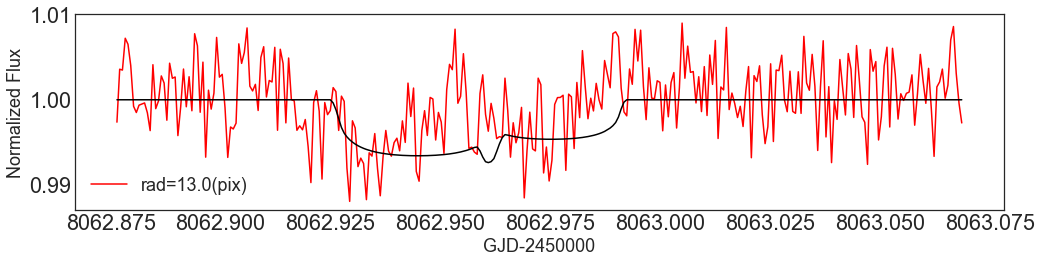

In [16]:
fig,ax = pl.subplots(1,1,figsize=(15,4),sharex=True)

time = df['GJD-2450000']
flux = df['flux(13)']

ax.plot(time, flux, label='rad=13.0(pix)', color ='red')

transit_params_d     = [k_d,tc_0d]
transit_params_e     = [k_e,tc_0e]

transit_params=transit_params_d+transit_params_e+[q1_,q2_]

transit_fix = [_Pd,a_s_d,_bd,_Pe,a_s_e,_be]

transit_model = transit_model_q(transit_params,transit_fix, time, model=MandelAgol())

ax.plot(time, transit_model , color ='black')

ax.set_xlabel('GJD-2450000')
ax.set_ylabel('Normalized Flux')
ax.legend(loc='lower left')
pl.tight_layout()
pl.savefig('figures/flux_with_theoretical_model.pdf')

TRAPPIST-1に関してはPeriodも変動の可能性が大きいのでtime以外すべてをフリーパラメタとし、初期値は理論値とした。
<font color="CornflowerBlue">transitの方はパラメタを固定したりフリーにしたりしなくていいか？</font>

### 2-3 systematicsのモデルを定義する

systematics = flux / transit_modelとして、各点のsystematics($s_i$)について

$s_i = w_1 X_{i1} + w_2 X_{i2} + \cdots $

という線形の組み合わせが成り立っているとする。($X_{im}$はairmassやdxのような要素、w_mはパラメタとなる重み。)  
これをベクトル表記すると

$\vec{s }= X \cdot \vec{w }$

と表される。pythonの行列計算を用いる。逆行列を求めるため正方行列にする必要があるので以下のようにしている。

$
X^T \cdot s = X^T \cdot X \cdot w \\
(X^T \cdot X)^{-1} \cdot X^T \cdot s = w
$

### 2-3-1. systematicsの組み合わせを用意する

systematicsが上記のような線形の組み合わせで表されると近似した場合、すべての要素を入れれば入れるほど正しい結果になるとは限らず、どの要素を入れるかを考慮する必要がある。  
プログラムを用いてその組み合わせを用意する。

In [17]:
import itertools
free=[['dx'],['dy'],['airmass'],['sky'],['time']]

seq1=['dx','dy','airmass','sky','time']
temp1=list(itertools.combinations(seq1,1))
temp2=list(itertools.combinations(seq1,2))
temp3=list(itertools.combinations(seq1,3))

m=0
for m in range(len(temp3)):
    b=[seq1[n] for n in range(len(seq1)) if not seq1[n] in temp3[m]]
    free.append(b)
    m += 1


m=0
for m in range(len(temp2)):
    b=[seq1[n] for n in range(len(seq1)) if not seq1[n] in temp2[m]]
    free.append(b)
    m += 1
    
m=0
for m in range(len(temp1)):
    b=[seq1[n] for n in range(len(seq1)) if not seq1[n] in temp1[m]]
    free.append(b)
    m += 1


free.append(seq1)
print(free)

[['dx'], ['dy'], ['airmass'], ['sky'], ['time'], ['sky', 'time'], ['airmass', 'time'], ['airmass', 'sky'], ['dy', 'time'], ['dy', 'sky'], ['dy', 'airmass'], ['dx', 'time'], ['dx', 'sky'], ['dx', 'airmass'], ['dx', 'dy'], ['airmass', 'sky', 'time'], ['dy', 'sky', 'time'], ['dy', 'airmass', 'time'], ['dy', 'airmass', 'sky'], ['dx', 'sky', 'time'], ['dx', 'airmass', 'time'], ['dx', 'airmass', 'sky'], ['dx', 'dy', 'time'], ['dx', 'dy', 'sky'], ['dx', 'dy', 'airmass'], ['dy', 'airmass', 'sky', 'time'], ['dx', 'airmass', 'sky', 'time'], ['dx', 'dy', 'sky', 'time'], ['dx', 'dy', 'airmass', 'time'], ['dx', 'dy', 'airmass', 'sky'], ['dx', 'dy', 'airmass', 'sky', 'time']]


上で用意したのは名前の組み合わせなので、ここから実際の値の組み合わせを準備する

In [18]:
df = df.rename(columns={'GJD-2450000': 'time'})
sys_combination = [] 

for n in range(len(free)):
    X=np.ones_like(time)
    m=0
    for m in range(len(free[n])):
        X=np.c_[X,df[free[n][m]]]
        m += 1
    sys_combination.append(X)
    n += 1
#sys_combination

このうちどの組み合わせを$X$として採用するかをフィッティングして（BIC等を基準にして）決めたい。$w$がフリーパラメタとなるが、初期値が適切でないとおかしな結果を出してしまうので、初期値として、OOT(Out-Of-Transit)からざっと求めた値を用いることにする。　　
### 2-3-2 各systematicsの組み合わせについて$\vec{w}$の値を求める
まず、OOTのデータ点(ざっと)を用意する。

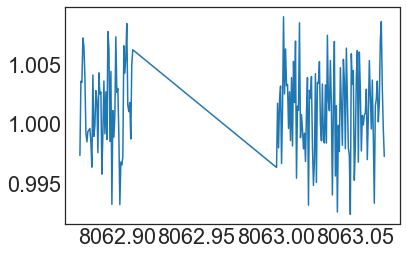

In [19]:
df2 = df[~((df['time']>8062.910) & (df['time']< 8063.00))]
time_OOT = df2['time']
flux_OOT = df2['flux(13)']
pl.plot(time_OOT,flux_OOT)

これについてwを求める

In [20]:
w_before = []
sys_combination_OOT = [] 
n=0
for n in range(len(free)):
    X=np.ones_like(time_OOT)
    m=0
    for m in range(len(free[n])):
        X=np.c_[X,df2[free[n][m]]]
        m += 1
    sys_combination_OOT.append(X)
    w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, flux_OOT))
    w_before.append(w)
    n += 1
w_before

[array([  1.00147027e+00,   1.40398316e-04]),
 array([  1.00076263e+00,  -4.52039034e-04]),
 array([  1.00050888e+00,   4.59316690e-04]),
 array([  9.99016961e-01,   4.14864774e-06]),
 array([  1.68639805e+01,  -1.96736044e-03]),
 array([  1.82224609e+01,   4.20979157e-06,  -2.13611567e-03]),
 array([  1.72902484e+01,   5.92889132e-04,  -2.02033450e-03]),
 array([  1.00044806e+00,  -1.12028338e-03,   4.52595297e-06]),
 array([  4.39301145e-01,  -4.54401813e-04,   6.96341474e-05]),
 array([  9.98818032e-01,  -4.18098429e-04,   3.79599020e-06]),
 array([  9.98066311e-01,  -5.02699352e-04,   1.82412911e-03]),
 array([ -4.22358424e+01,   4.17165668e-04,   5.36251455e-03]),
 array([  9.99278915e-01,   1.53476455e-04,   4.26310268e-06]),
 array([  1.00051833e+00,   1.44061360e-04,   6.60560241e-04]),
 array([  1.00087350e+00,   4.20295913e-05,  -4.27094172e-04]),
 array([  1.76180701e+01,  -9.89204096e-04,   4.54079993e-06,
         -2.06100014e-03]),
 array([  3.34403136e+00,  -4.08079112e-

これで各systematicsの組み合わせについて$w$のおよその値が求められた。例えば

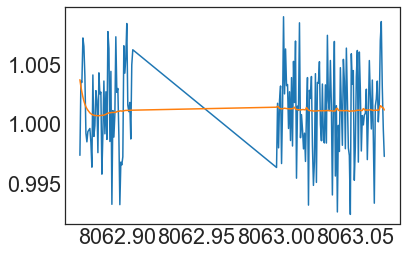

In [21]:
w=w_before[7]
X=sys_combination_OOT[7]
sys_model = np.dot(X,w)

pl.plot(time_OOT,flux_OOT)
pl.plot(time_OOT,sys_model)

## 4. 各パラメタセットでフィットし最も良いセットを決める(MLE)

### 4-1 基準1: Bayesian Information Criteria (BIC)

In [22]:
def rms(flux,flux_model):
    residual = flux-flux_model
    return np.sqrt(np.mean((residual)**2))

def chisq(flux,flux_model,err):
    residual = flux-flux_model
    return np.sum((residual/err)**2)

#BIC = chi2 + num_p * np.log(num_d)

### 4-2 基準2: red noise factor $\beta \times$ rms 

In [23]:
def binned(a, binsize, fun=np.mean):
    a_b = []
    for i in range(0, a.shape[0], binsize):
        a_b.append(fun(a[i:i+binsize], axis=0))
        
    return a_b

def beta(residuals, timestep, start_min=5, stop_min=20, return_dict=False):
    """
    residuals : flux/sys_model - transit_model
    timestep  : time interval between datapoints in seconds
    
    Final beta is computed by taking the median of the betas:
                np.nanmedian(betas)
    """

    assert timestep < start_min * 60
    ndata = len(residuals)
    
    sigma1 = np.std(residuals)

    min_bs = int(start_min * 60 / timestep)
    max_bs = int(stop_min  * 60 / timestep)
    #5*60/50=6points/bin
    #20*60/50=24points/bin

    betas      = []
    betas_dict = {}
    for bs in np.arange(min_bs, max_bs + 1):
        #6,7,...,24
        nbins = ndata / bs
        #sigmaN_theory = sigma1 / np.sqrt(bs) 最後の項の意味?(Winn J+(2008))
        sigmaN_theory = sigma1 / np.sqrt(bs) * np.sqrt( nbins / (nbins - 1) )
        
        #binning
        sigmaN_actual = np.std(binned(residuals,bs))
        beta = sigmaN_actual / sigmaN_theory
        
        betas_dict[bs] = beta
        betas.append(beta)
        
    #return_dict=TRUEなら辞書を返す、FALSEなら(無記入なら)メディアンとったbetaを返す
    if return_dict:
        return betas_dict
    else:
        return np.nanmedian(betas)

### 4-3 フィッティング

最小にする関数を定義。

In [24]:
import scipy.optimize as op

def obj (params_full, fix, t, f, err):
    '''
    objective function: chi-squared
    '''
    transit_params=params_full[:6]
    sys_params=params_full[6:]
    
    m = transit_model_q(transit_params, fix,t, model=MandelAgol())
    s = np.dot(sys_use,sys_params)
    
    return np.sum(((f-s*m)/err)**2)

使う(最適化する)パラメタを整える。たとえばsystematicsの組み合わせの13番目、['dx', 'airmass']を使うならば、

In [25]:
time = df['time']

flux = df['flux(13)']
err  = df['err(13)']
    
dx   = df['dx']
dy   = df['dy']
airmass = df['airmass']
sky     = df['sky']

transit_params_d     = [k_d,tc_0d]
transit_params_e     = [k_e,tc_0e]

transit_params=transit_params_d+transit_params_e+[q1_,q2_]
sys_use = sys_combination[13]
w = w_before[13]

#combine optimized transit params and sys params
full_params = np.concatenate((transit_params, w), axis=0)
full_params

array([  6.04923922e-02,   8.06297518e+03,   7.19326633e-02,
         8.06294490e+03,   8.48977960e-01,   2.02572173e-01,
         1.00051833e+00,   1.44061360e-04,   6.60560241e-04])

順に、惑星dの$k$,$T_c$、  
惑星eの$k$,$T_c$、  
lim-darkningの$q_1$,$q_2$、  
使用するsystematicsのウェイト$\vec{w}$
である。  

In [26]:
result = op.minimize(obj, full_params, args=(transit_fix,time,flux,err), method='nelder-mead')

#compute flux after optimization
params_after     = np.copy(result.x)
transit_params_after = params_after[:6]
sys_params_after = params_after[6:]

transit_model = transit_model_q(transit_params_after,transit_fix, time, model=MandelAgol())
sys_model = np.dot(sys_use,sys_params_after)
print('\nsystematics is' ,free[13])
#compute rms
rms_after = rms(flux/sys_model, transit_model)
print('rms w/o systematics:\n{:.8f}'.format(rms_after))
        
#compute BIC
num_d=len(time)
num_p=full_params.size
chi2 = chisq(flux/sys_model,transit_model,err)
        
dof = num_d - num_p
red_chi2 = chi2 / dof
BIC = chi2 + num_p * np.log(num_d)
        
print('chisq:\n{:.8f}'.format(chi2))
print('reduced_chisq:\n{:.8f}'.format(red_chi2))
print('BIC: {:.4f}'.format(BIC))
    
#compute beta
exptime = 50 #sec
    
resid = flux/sys_model-transit_model
beta_fac = beta(resid, exptime, start_min=5, stop_min=20)
           
inflated_err = err * beta_fac
beta_rms = rms_after * beta_fac
#print('beta factor ={:.4f}'.format(beta_fac))
print('beta * rms ={:.9f}'.format(beta_rms))


systematics is ['dx', 'airmass']
rms w/o systematics:
0.00365900
chisq:
259.55493382
reduced_chisq:
0.87984723
BIC: 311.0082
beta * rms =0.003709076


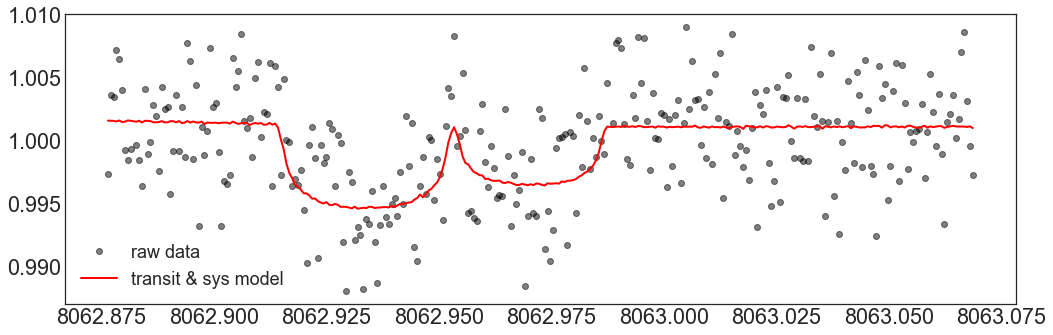

In [27]:
fig = pl.figure(figsize=(15,5))
#plot corrected data
pl.plot(time, flux, 'ko', alpha=0.5, label='raw data')
#pl.set_title('raw data & transit+systematics models (z-band)', fontsize=18)
#plot transit+sys models
pl.plot(time, transit_model*sys_model, 'r-', lw=2, label='transit & sys model');

pl.legend(fontsize=18)
fig.tight_layout()

同様のことを3つのアパーチャー、31パターンのパラメタの組み合わせで行い、BICと$\beta \times rms$を計算する。

In [60]:
time = df['time']

radii = ['13pix']
flux_list = [df['flux(13)']]
err_list = [df['err(13)']*0.935]


transit_params_d     = [k_d,tc_0d]
transit_params_e     = [k_e,tc_0e]

transit_params=transit_params_d+transit_params_e+[q1_,q2_]

BIC_list = []
rms_list=[]
beta_rms_list = []
reduced_chisq_list = []


m=0
count = 0

for m in range(len(flux_list)):
    print('\naperture radius =' + radii[m])
    flux = flux_list[m]
    err = err_list[m]
    
    n=0
    for n in range(len(w_before)):
        sys_use = sys_combination[n]
        w = w_before[n]
        full_params = np.concatenate((transit_params, w), axis=0)
    
        result = op.minimize(obj, full_params, args=(transit_fix,time,flux,err), method='nelder-mead')

        #compute flux after optimization
        params_after     = np.copy(result.x)
        transit_params_after = params_after[:6]
        sys_params_after = params_after[6:]

        transit_model = transit_model_q(transit_params_after,transit_fix, time, model=MandelAgol())
        sys_model = np.dot(sys_use,sys_params_after)
        print('\nnumber',count)
        print('systematics is' ,free[n])
        #compute rms
        rms_after = rms(flux/sys_model, transit_model)
        print('rms w/o systematics:\n{:.8f}'.format(rms_after))
        
        #compute BIC
        num_d=len(time)
        num_p=full_params.size
        chi2 = chisq(flux/sys_model,transit_model,err)
        
        dof = num_d - num_p
        red_chi2 = chi2 / dof
        BIC = chi2 + num_p * np.log(num_d)
        
        #print('chisq:\n{:.8f}'.format(chi2))
        print('reduced_chisq:\n{:.8f}'.format(red_chi2))
        print('BIC: {:.4f}'.format(BIC))
    
        #compute beta
        exptime = 50 #sec
    
        resid = flux/sys_model-transit_model
        beta_fac = beta(resid, exptime, start_min=5, stop_min=20)
           
        inflated_err = err * beta_fac
        beta_rms = rms_after * beta_fac
        #print('beta factor ={:.4f}'.format(beta_fac))
        print('beta * rms ={:.9f}'.format(beta_rms))
        
        BIC_list.append(BIC)
        rms_list.append(rms_after)
        beta_rms_list.append(beta_rms)
        reduced_chisq_list.append(red_chi2)
        
        n += 1
        count += 1
    m += 1


aperture radius =13pix

number 0
systematics is ['dx']
rms w/o systematics:
0.00365461
reduced_chisq:
1.00043730
BIC: 341.8657
beta * rms =0.003666077

number 1
systematics is ['dy']
rms w/o systematics:
0.00364175
reduced_chisq:
0.99281749
BIC: 339.6102
beta * rms =0.003561366

number 2
systematics is ['airmass']
rms w/o systematics:
0.00366822
reduced_chisq:
1.00796017
BIC: 344.0924
beta * rms =0.003735847

number 3
systematics is ['sky']
rms w/o systematics:
0.00364707
reduced_chisq:
0.99627053
BIC: 340.6323
beta * rms =0.003634729

number 4
systematics is ['time']
rms w/o systematics:
0.00365688
reduced_chisq:
1.00169251
BIC: 342.2372
beta * rms =0.003662139

number 5
systematics is ['sky', 'time']
rms w/o systematics:
0.00363895
reduced_chisq:
0.99501403
BIC: 344.9824
beta * rms =0.003584088

number 6
systematics is ['airmass', 'time']
rms w/o systematics:
0.00366084
reduced_chisq:
1.00743876
BIC: 348.6477
beta * rms =0.003701801

number 7
systematics is ['airmass', 'sky']
rms w/

これで全ての場合のBICと$\beta\times$rmsが計算できた。これを小さい順に並び替える。

In [61]:
df_criteria=pd.DataFrame({'BIC':BIC_list,'beta*rms':beta_rms_list,'rms':rms_list,'free':free,'reduced chi2':reduced_chisq_list})
df_criteria=df_criteria[['free','BIC','rms','beta*rms','reduced chi2']]
df_criteria.head(3)

,free,BIC,rms,beta*rms,reduced chi2
0,[dx],341.865661,0.003655,0.003666,1.000437
1,[dy],339.610200,0.003642,0.003561,0.992817
2,[airmass],344.092432,0.003668,0.003736,1.007960


In [62]:
df_criteria.sort_values(by=["BIC"], ascending=True).head(10)

,free,BIC,rms,beta*rms,reduced chi2
1,[dy],339.610200,0.003642,0.003561,0.992817
3,[sky],340.632298,0.003647,0.003635,0.996271
0,[dx],341.865661,0.003655,0.003666,1.000437
4,[time],342.237205,0.003657,0.003662,1.001693
9,"[dy, sky]",343.439330,0.003631,0.003505,0.989783
7,"[airmass, sky]",343.965507,0.003632,0.003547,0.991567
2,[airmass],344.092432,0.003668,0.003736,1.007960
12,"[dx, sky]",344.539424,0.003636,0.003601,0.993512
5,"[sky, time]",344.982389,0.003639,0.003584,0.995014
14,"[dx, dy]",345.015493,0.003640,0.003571,0.995126


In [63]:
df_criteria.sort_values(by=["rms"], ascending=True).head(10)

,free,BIC,rms,beta*rms,reduced chi2
21,"[dx, airmass, sky]",348.495489,0.003626,0.003543,0.990902
15,"[airmass, sky, time]",348.794937,0.003627,0.003521,0.991921
23,"[dx, dy, sky]",348.619796,0.003627,0.003515,0.991325
26,"[dx, airmass, sky, time]",354.567868,0.003628,0.003578,0.995497
27,"[dx, dy, sky, time]",354.371224,0.003628,0.003565,0.994826
16,"[dy, sky, time]",349.042419,0.003630,0.003505,0.992762
29,"[dx, dy, airmass, sky]",354.820298,0.003630,0.003534,0.996358
9,"[dy, sky]",343.439330,0.003631,0.003505,0.989783
7,"[airmass, sky]",343.965507,0.003632,0.003547,0.991567
30,"[dx, dy, airmass, sky, time]",360.821278,0.003632,0.003587,1.000743


BIC、$\beta\times$rmsのそれぞれで小さい順に並べ替え、上位10組をみるとあまりかぶっていない・・・。  
とりあえずBICからは、rad=13pixが最もよくフィッティングされているとわかる。  
32番(rad=13pix, systematics='dy')と40番(rad=13pix, systematics ='dy,sky')が特に小さそうだが・・。  
以前、先にトランジットのモデルをフィットしてから割ってsystematicsを変化させたときはairmassを補正した時が一番BICやbeta*rmsが小さくなったのだが、今回はairmassはあまり効いてこなかったのが不思議だ。

以下、適切と思われるいくつかの組み合わせについてライトカーブを描いてみる。


systematics is ['dx', 'dy', 'sky']
rms w/o systematics:
0.00362708
chisq:
254.71878155
reduced_chisq:
0.88444021
BIC: 346.1912
beta * rms =0.003430296


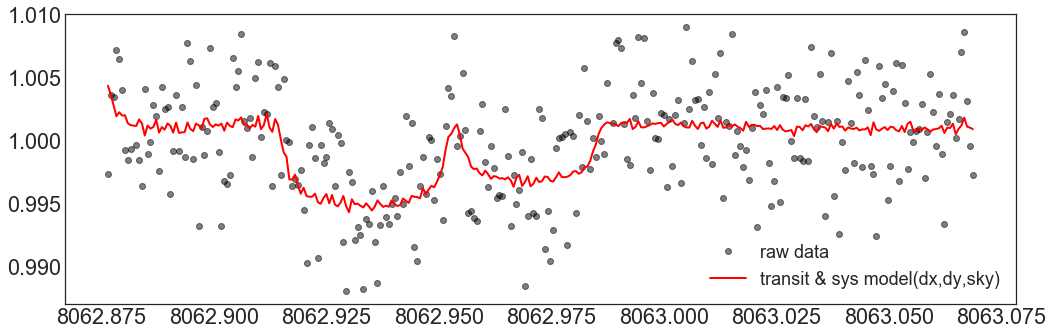

In [37]:
time = df['time']

flux = df['flux(13)']
err  = df['err(13)']

dy   = df['dy']
sky     = df['sky']

transit_params_d     = [k_d,tc_0d,a_s_d,_bd,_Pd]
transit_params_e     = [k_e,tc_0e,a_s_e,_be,_Pe]

transit_params=transit_params_d+transit_params_e+[q1_,q2_]
sys_use = sys_combination[23]
w = w_before[23]

#combine optimized transit params and sys params
full_params = np.concatenate((transit_params, w), axis=0)
result = op.minimize(obj, full_params, args=(time,flux,err), method='nelder-mead')

#compute flux after optimization
params_after     = np.copy(result.x)
params_after_13_dy_sky =params_after
transit_params_after = params_after[:12]
sys_params_after = params_after[12:]

transit_model = transit_model_q(transit_params_after, time, model=MandelAgol())
sys_model = np.dot(sys_use,sys_params_after)
print('\nsystematics is' ,free[23])
#compute rms
rms_after = rms(flux/sys_model, transit_model)
print('rms w/o systematics:\n{:.8f}'.format(rms_after))
        
#compute BIC
num_d=len(time)
num_p=full_params.size
chi2 = chisq(flux/sys_model,transit_model,err)
        
dof = num_d - num_p
red_chi2 = chi2 / dof
BIC = chi2 + num_p * np.log(num_d)
        
print('chisq:\n{:.8f}'.format(chi2))
print('reduced_chisq:\n{:.8f}'.format(red_chi2))
print('BIC: {:.4f}'.format(BIC))
    
#compute beta
exptime = 50 #sec
    
resid = flux/sys_model-transit_model
beta_fac = beta(resid, exptime, start_min=5, stop_min=20)
           
inflated_err = err * beta_fac
beta_rms = rms_after * beta_fac
#print('beta factor ={:.4f}'.format(beta_fac))
print('beta * rms ={:.9f}'.format(beta_rms))

fig = pl.figure(figsize=(15,5))
#plot corrected data
pl.plot(time, flux, 'ko', alpha=0.5, label='raw data')
#pl.set_title('raw data & transit+systematics models (z-band)', fontsize=18)
#plot transit+sys models
pl.plot(time, transit_model*sys_model, 'r-', lw=2, label='transit & sys model(dx,dy,sky)');

pl.legend(fontsize=18)
fig.tight_layout()
pl.savefig('figures/dxdysky.pdf')

## 5. 最も良いパラメタセットでフィッティングする(MCMC)
### 5-1 likelihoodの準備

<font color=red>ここからやりかけ</font>  
ここからはMCMCを使う。
ベイズの定理より
$$
P(\theta|D) \propto P(\theta) \times P(D|\theta) \\
\rm{Posterior \propto Prior \times Likelihood}
$$
ここで$P(\theta)$ は prior, $P(D|\theta)$ は likelihood。

likelihoodをガウシアンとして
$$
\mathcal{L}(\theta|M) = N(\mu,\sigma) = \prod_{n=1}^{N}\frac{1}{\sqrt{2\pi \sigma^2}} \exp\left(-\frac{(x_n-\mu)^2}{2\sigma^2}\right)
$$
logをとると
$$
\log \mathcal{L}(\theta|D) = -\frac{1}{2}\Big[N\log(2\pi) +2N\log\sigma +\sum_{n=1}^{N}\Big(\frac{x_n-\mu}{\sigma}\Big)^2\Big]
$$

<font color=red>Jeromeのコードではこの後$\sigma$にerrを利用しているけどそれでいいのか？？rmsとかでなく？</font>  

In [132]:
def loglike(params_full, t, f, err, X,
            ret_mod=False, ret_sys=False, ret_full = False):
    '''
    * computes the log likelihood given the optimized transit and model parameters
    * either or both transit and systematics models can also be returned
    '''
    
    m = transit_model_q(params_full[:12], t)
   
    w= params_full[12:]
    
    s = np.dot(X,w)  
    
    if ret_mod:
        return m
    if ret_sys:
        return s
    if ret_full:
        return m * s
    
    resid = f / s - m
    div   = resid/err
    N     = div.size
    
    return -sum(np.log(err)) -0.5*N*np.log(2*np.pi) -0.5*np.dot(div,div)

### 5-2 priorの準備
prior（uniformか？normalか？上限、下限は？）を物理的に適した値に設定する。

uniform priorが適しているのは
* Impact parameter
* White noise std
* limb darkening q1
* limb darkening q2

normal prior $N(\sigma,\mu)$が適しているのは
* Transit center
* Period
* Stellar density
* Baseline constant
* planet-star area ratio

各物理量に不確かさを入れた値を再度用意する。

In [89]:
import numpy as np
from uncertainties import ufloat 
from astropy import units as u

Rs   = ufloat(0.117,0.0036)#R_sun

Pe   = ufloat(6.099570,0.000091)#days これはTTV入ってないけどいいのか・・
Rpe  = ufloat(0.918,0.039) #R_earth

be   = ufloat(0.12,0.11)#+0.11/-0.09     
ae   = ufloat(0.02817,0.00087) #AU +0.00083/-0.00087

ke   = Rpe/Rs/u.Rsun.to(u.Rearth)
a_se = ae/Rs/u.Rsun.to(u.au)

Pd   = ufloat(4.04982,0.00017)#days
Rpd  = ufloat(0.772,0.030) #R_earth

bd   = ufloat(0.17,0.11)  
ad = ufloat(0.02144,0.00066) #AU +0.00066/-0.00063

kd   = Rpd/Rs/u.Rsun.to(u.Rearth)
a_sd = ad/Rs/u.Rsun.to(u.au)

priorを決める元となる様々な基準を用意

In [91]:
def tshape_approx(a, k, b):
    """
    Seager & Mallen-Ornelas 2003, eq. 15
    """
    i = np.arccos(b/a)
    alpha = (1 - k)**2 - b**2
    beta = (1 + k)**2 - b**2
    return np.sqrt( alpha / beta )


def max_k(tshape):
    """
    Seager & Mallen-Ornelas 2003, eq. 21
    """
    return (1 - tshape) / (1 + tshape)

In [134]:
from astropy import constants
from astropy import units

def rhostar(p, a): #これ理解しないと・・・Pとasに制限を加える
    """
    Eq.4 of Kipping 2014. 
    Assumes circular orbit & Mp<<Ms
    
    http://arxiv.org/pdf/1311.1170v3.pdf
    
    c.f. Seager & __ 2002
    """
    p = p * units.d
    gpcc = units.g / units.cm ** 3
    rho_mks = 3 * np.pi / constants.G / p ** 2 * a ** 3
    return rho_mks.to(gpcc).value

In [121]:
from scipy import stats
def logprior(full_params):
    '''
    full_paras: transit+systematic model parameters
    up: limb-darkening prior for u1,u2
    '''
    #unpack transit parameters
    k_d,tc_d,a_s_d,b_d,p_d,k_e,tc_e,a_s_e,b_e,p_e,q1,q2 = full_params[:12]
    
    inc_d=np.arccos(b_d/a_s_d)
    inc_e=np.arccos(b_e/a_s_e)
    
    tshape_d = tshape_approx(a_s_d, k_d, b_d)
    tshape_e = tshape_approx(a_s_e, k_e, b_e)
    
    kmax_d = max_k(tshape_d)
    kmax_e = max_k(tshape_e)
    
    rho_s_d = rhostar(p_d, a_s_d)
    rho_s_e = rhostar(p_e, a_s_e)

    time_start = df['time'][0]
    time_end = df['time'][305]
    
    #Uniform priors: return log 0= inf if outside interval
    if  q1  < 0 or q1 > 1 or \
        q2  < 0 or q2 > 1 or \
        k_d   < 0 or k_d  > kmax_d or \
        k_e   < 0 or k_e  > kmax_e or \
        b_d   < 0 or b_d > 1 or \
        b_e   < 0 or b_e > 1 or \
        inc_d > np.pi/2 or \
        inc_e > np.pi/2 or \
        a_s_d < 0 or a_s_d  > 13 or \
        a_s_e < 0 or a_s_e  > 13 or \
        rho_s_d < 1 or rho_s_d > 10 or \
        rho_s_e < 1 or rho_s_e > 10:
        #tc_d　< time_start or  tc_d > time_end:
        #tc_e　< time_start or  tc_e > time_end:
        
        #print('off limits encountered in logprior')
        return -np.inf
    
    #if they are inside interval, add log 1 = 0 to logprior
    
    #logprior
    lp = 0
    
    #Normal priors on q1,q2 with sigma=uncertainty from Claret+2012
    u1,u2 = q_to_u(q1,q2)
    
    return lp

loglikeとlogpriorからlogprobを計算

In [129]:
def logprob(full_params,
            time,
            flux,
            X,
            err):
    
    #sum loglike for each band
    ll  = loglike(full_params, time, flux, err, X)
    lp  = logprior(full_params)
    
    if np.isnan(ll).any():
        #print('NaN encountered in loglike')
        return -np.inf
    
    #total: sum of prior and likelihood
    return lp + ll

#negative log prob
nlp = lambda *x: -logprob(*x)

今ある値を入れてみてlogprobを確認

In [135]:
time = df['time']
flux = df['flux(13)']
err  = df['err(13)']
dy     = df['dy']
sky   = df['sky']

full_params = params_after_13_dy_sky
X = np.c_[np.ones_like(time),dy,sky]

logprob(full_params,
        time,
        flux,
        X,
        err)

-inf

あれぇ

In [77]:
import emcee
emcee.EnsembleSampler?